### Notebook for creating manuscript figures

### Imports

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pypsa
import warnings
import yaml
warnings.filterwarnings("ignore")
import pickle
import os

from matplotlib import rc
rc('text', usetex=False)

In [3]:
with open('./tech_colors.yaml') as file:
    tech_colors = yaml.safe_load(file)['tech_colors']
tech_colors['ambient heat'] = tech_colors['heat pumps']

In [4]:
override_component_attrs = pypsa.descriptors.Dict({k : v.copy() for k,v in pypsa.components.component_attrs.items()})
override_component_attrs["Link"].loc["bus2"] = ["string",np.nan,np.nan,"2nd bus","Input (optional)"]
override_component_attrs["Link"].loc["bus3"] = ["string",np.nan,np.nan,"3rd bus","Input (optional)"]
override_component_attrs["Link"].loc["bus4"] = ["string",np.nan,np.nan,"4th bus","Input (optional)"]
override_component_attrs["Link"].loc["efficiency2"] = ["static or series","per unit",1.,"2nd bus efficiency","Input (optional)"]
override_component_attrs["Link"].loc["efficiency3"] = ["static or series","per unit",1.,"3rd bus efficiency","Input (optional)"]
override_component_attrs["Link"].loc["efficiency4"] = ["static or series","per unit",1.,"4th bus efficiency","Input (optional)"]
override_component_attrs["Link"].loc["p2"] = ["series","MW",0.,"2nd bus output","Output"]
override_component_attrs["Link"].loc["p3"] = ["series","MW",0.,"3rd bus output","Output"]
override_component_attrs["Link"].loc["p4"] = ["series","MW",0.,"4th bus output","Output"]

In [5]:
network = pypsa.Network('../results/version-gaslimit3100-3H/postnetworks/elec_s370_37m_lv1.0__3H-T-H-B-I-solar+p3-dist1-cb25.7ex0_2020.nc',override_component_attrs=override_component_attrs)

INFO:pypsa.io:Imported network elec_s370_37m_lv1.0__3H-T-H-B-I-solar+p3-dist1-cb25.7ex0_2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [6]:
fs = 18
plt.rcParams['axes.labelsize'] = fs
plt.rcParams['xtick.labelsize'] = fs
plt.rcParams['ytick.labelsize'] = fs

In [7]:
def import_df(path,scenario,n_index=3,n_header=4):
    df = pd.read_csv(path,index_col=list(range(n_index)),header=list(range(n_header)))
    df = df.droplevel(0,axis=1)
    df = df.droplevel(0,axis=1)
    df = df.loc[:,['3H-T-H-B-I-solar+p3-dist1-cb25.7ex0','3H-T-H-B-I-solar+p3-dist1-cb73.9ex0','3H-T-H-B-I-solar+p3-dist1-cb25.7ex0-gasconstrained','3H-T-H-B-I-solar+p3-dist1-cb73.9ex0-gasconstrained']]
    #df.drop(['3H-T-H-B-I-solar+p3-dist1-cb35.4ex0','3H-T-H-B-I-solar+p3-dist1-cb45.0ex0','3H-T-H-B-I-solar+p3-dist1-cb54.7ex0','3H-T-H-B-I-solar+p3-dist1-cb64.3ex0'],axis=1,inplace=True)
    df.rename(columns={'3H-T-H-B-I-solar+p3-dist1-cb25.7ex0':f'1.5_base','3H-T-H-B-I-solar+p3-dist1-cb73.9ex0':f'2_base',
                        '3H-T-H-B-I-solar+p3-dist1-cb25.7ex0-gasconstrained':'1.5_no_gas','3H-T-H-B-I-solar+p3-dist1-cb73.9ex0-gasconstrained':'2_no_gas'},level=0,inplace=True)
    return df


In [8]:
supply_energy = import_df('../results/version-gaslimit3100-3H/csvs/supply_energy.csv','no_gas')
nodal_capacities = import_df('../results/version-gaslimit3100-3H/csvs/nodal_capacities.csv','no_gas')
energy = import_df('../results/version-gaslimit3100-3H/csvs/energy.csv','no_gas')
costs = import_df('../results/version-gaslimit3100-3H/csvs/costs.csv','no_gas')
metrics = import_df('../results/version-gaslimit3100-3H/csvs/metrics.csv','no_gas',1)
prices = import_df('../results/version-gaslimit3100-3H/csvs/price_statistics.csv','no_gas',1)

### Make gas price df

In [9]:
p = '../results/version-gaslimit3100-3H/postnetworks/'
files = os.listdir(p)
gas_prices = {}
for f in files:
    if f[-1]=='p' and f[-21:-7] == 'gasconstrained':
        year = int(f[-6:-2])
        gas_price = float(pickle.load( open(p+f, "rb" ))[0]['Generator']['df']['gas_limit'].values)
        if f[-29:-25] == '73.9':
            scenario = '2'
        elif f[-29:-25] == '25.7':
            scenario = '1.5'
        
        gas_prices[scenario+'_'+str(year)] = (year,scenario,gas_price)
        
gas_prices = pd.DataFrame(data=gas_prices.values(),columns=['year','scenario','gas_price'])

### Helper function

In [10]:
def rename_techs(label):

    prefix_to_remove = [
        "residential ",
        "services ",
        "urban ",
        "rural ",
        "central ",
        "decentral "
    ]

    rename_if_contains = [
        "CHP",
        "gas boiler",
        "biogas",
        "solar thermal",
        "air heat pump",
        "ground heat pump",
        "resistive heater",
        "Fischer-Tropsch"
    ]

    rename_if_contains_dict = {
        "water tanks": "hot water storage",
        "retrofitting": "building retrofitting",
        # "H2 Electrolysis": "hydrogen storage",
        # "H2 Fuel Cell": "hydrogen storage",
        # "H2 pipeline": "hydrogen storage",
        "battery": "battery storage",
        # "CC": "CC"
    }

    rename = {
        "solar": "solar PV",
        "Sabatier": "methanation",
        "offwind": "offshore wind",
        "offwind-ac": "offshore wind (AC)",
        "offwind-dc": "offshore wind (DC)",
        "onwind": "onshore wind",
        "ror": "hydroelectricity",
        "hydro": "hydroelectricity",
        "PHS": "hydroelectricity",
        "co2 Store": "DAC",
        "co2 stored": "CO2 sequestration",
        "AC": "transmission lines",
        "DC": "transmission lines",
        "B2B": "transmission lines",
        'uranium':'nuclear'
    }

    for ptr in prefix_to_remove:
        if label[:len(ptr)] == ptr:
            label = label[len(ptr):]

    for rif in rename_if_contains:
        if rif in label:
            label = rif

    for old,new in rename_if_contains_dict.items():
        if old in label:
            label = new

    for old,new in rename.items():
        if old == label:
            label = new
    return label

## Capacity plots

### Renewable generator capacities

In [12]:
def gen_df_for_cap_plot():

        df_ren = nodal_capacities.loc[('generators',slice(None),slice(None))].groupby(level=2).sum()
        renewable_techs = ['offwind',
                'offwind-ac',
                'offwind-dc',
                'onwind',
                'solar',
                'solar rooftop',
                'residential rural solar thermal',
                'residential urban decentral solar thermal',
                'services rural solar thermal',
                'services urban decentral solar thermal',
                'urban central solar thermal',
                'ror'
                ]
        df_ren = df_ren.loc[renewable_techs]
        df_ren = df_ren.groupby([rename_techs(t)for t in renewable_techs]).sum() * 1e-3
        df_ren.rename(index={'offshore wind':'wind',
                        'offshore wind (AC)':'wind',
                        'offshore wind (DC)':'wind',
                        'onshore wind':'wind',
                        'solar PV':'solar',
                        'solar rooftop':'solar',
                        'solar thermal':'solar'
                        },inplace=True)
        df_ren = df_ren.groupby(level=0).sum()

        df_ren.loc['hydroelectricity'] = nodal_capacities.loc[('storage_units',slice(None),'hydro')].sum()*1e-3 + df_ren.loc['hydroelectricity']

        fossil_generetor_techs = ['nuclear',  ]
        df_fosil = nodal_capacities.loc[('links',slice(None),fossil_generetor_techs)]
        df_fosil= df_fosil.groupby(level=2).sum() * 1e-3

        df = pd.concat((df_ren,df_fosil))
        return df

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


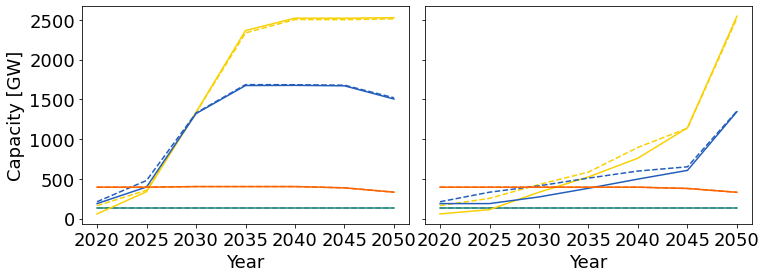

In [13]:
df = gen_df_for_cap_plot()

fig,axes = plt.subplots(1,2,figsize=(12,4),sharex=True,sharey='row')
axes = axes.flatten()

for i,scen in enumerate(['1.5','2']):
    df_i = df.loc[:,[f'{scen}_base',f'{scen}_no_gas']].T.unstack(level=0)
    df_i.index = df_i.index.astype(int)
    df_i.plot(color=[tech_colors[t] for t in list(df_i.columns.get_level_values(0))],
                style=['-','--']*10,
                ax=axes[i],
                legend=False)
    axes[i].set_ylabel('Capacity [GW]')
    axes[i].set_xlabel('Year')
    axes[i].xaxis.set_major_locator(plt.MaxNLocator(7))
    #if i >=2:
    #    axes[i].set_ylim(0,500)
    #else :
    #    axes[i].set_ylim(500,3000)
#
fig.subplots_adjust(wspace=0.05)
#plt.tight_layout()


### Renewable capacities

In [14]:
df = nodal_capacities.loc[('generators',slice(None),slice(None))].groupby(level=2).sum()
renewable_techs = ['offwind',
        'offwind-ac',
        'offwind-dc',
        'onwind',
        'solar',
        'solar rooftop',
        'residential rural solar thermal',
        'residential urban decentral solar thermal',
        'services rural solar thermal',
        'services urban decentral solar thermal',
        'urban central solar thermal',
        'ror']
df = df.loc[renewable_techs]
df = df.groupby([rename_techs(t)for t in renewable_techs]).sum() * 1e-3
df.rename(index={'offshore wind':'offshore wind','offshore wind (AC)':'offshore wind','offshore wind (DC)':'offshore wind'},inplace=True)
df = df.groupby(level=0).sum()
df  = df.iloc[::-1]

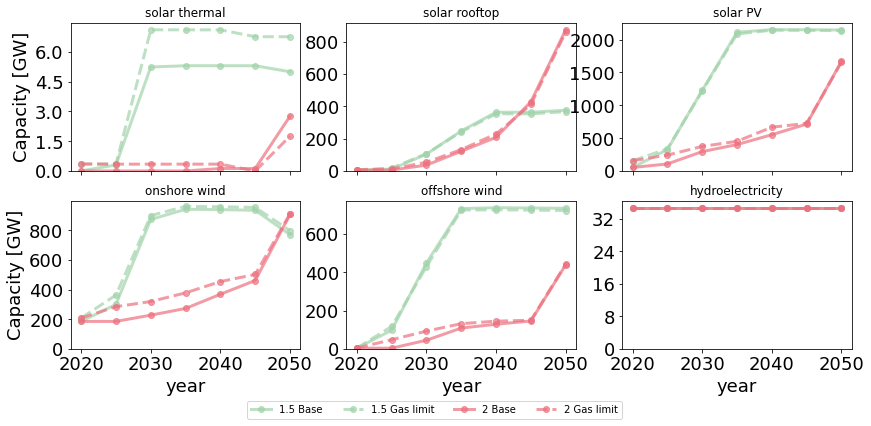

In [15]:
fig,axes = plt.subplots(2,3,figsize=(14,6),sharex=True)
axes = axes.flatten()

for i,tech in enumerate(df.index):
    df_i = df.loc[tech].unstack(level=0)
    df_i.index = df_i.index.astype(int)
    df_i.rename(columns={'1.5_base':'1.5 Base','1.5_no_gas':'1.5 Gas limit','2_base':'2 Base','2_no_gas':'2 Gas limit'},inplace=True)

    df_i.plot(ax=axes[i],legend=False,
                style=['-','--','-','--'],
                color=['#A2D4AB','#A2D4AB','#ED717F','#ED717F'],
                marker='o',
                alpha=0.7,
                linewidth=3,
                #color=['tab:blue','tab:blue','tab:orange','tab:orange']
                )
    axes[i].set_title(rename_techs(tech))
    start,end = axes[i].get_ylim()
    axes[i].set_ylim(0,end)
    axes[i].yaxis.set_major_locator(plt.MaxNLocator(5))
    axes[i].set_xlabel('year')
axes[0].set_ylabel('Capacity [GW]')
axes[3].set_ylabel('Capacity [GW]')
axes[-1].legend(ncol=4,bbox_to_anchor=(0, -0.35),borderaxespad=0)

plt.savefig('../figures/renewable_capacites.pdf',bbox_inches='tight')


### Fosil generator capacities

In [16]:
fossil_generetor_techs = ['CCGT',
                            'OCGT',
                            'coal',
                            #'coal CC',
                            'lignite',
                            'oil',
                            'nuclear',
                            'urban central gas CHP',
                            #'urban central gas CHP CC',
                            'urban central solid biomass CHP',
                            'urban central solid biomass CHP CC'
                            ]
df = nodal_capacities.loc[('links',slice(None),fossil_generetor_techs)]

df= df.groupby(level=2).sum() * 1e-3
#df = df.groupby([rename_techs(t)for t in df.index]).sum() * 1e-3

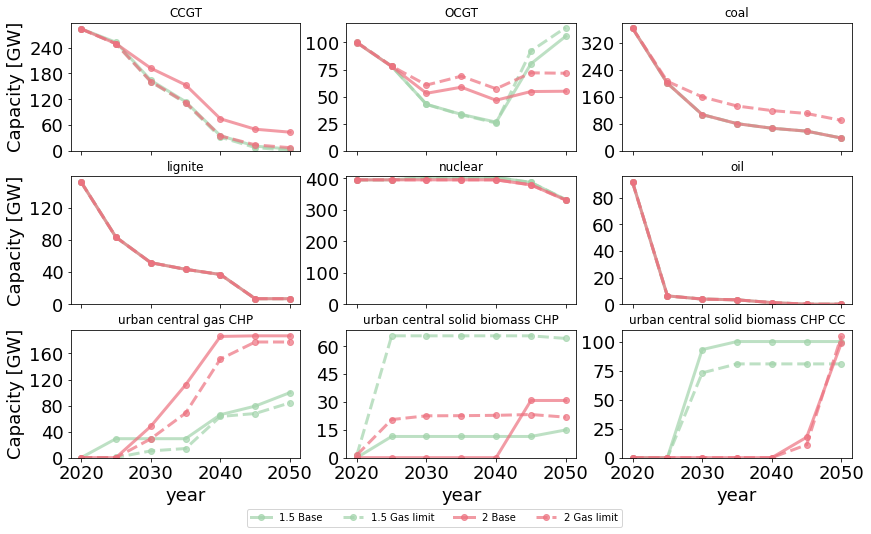

In [17]:
fig,axes = plt.subplots(3,3,figsize=(14,8),sharex=True)
axes = axes.flatten()

for i,tech in enumerate(df.index):
    df_i = df.loc[tech].unstack(level=0)
    df_i.index = df_i.index.astype(int)
    df_i.rename(columns={'1.5_base':'1.5 Base','1.5_no_gas':'1.5 Gas limit','2_base':'2 Base','2_no_gas':'2 Gas limit'},inplace=True)

    df_i.plot(ax=axes[i],
                legend=False,
                style=['-','--','-','--'],
                color=['#A2D4AB','#A2D4AB','#ED717F','#ED717F'],
                marker='o',
                alpha=0.7,
                linewidth=3,
                #color=['tab:blue','tab:blue','tab:orange','tab:orange']
                )
    axes[i].set_title(tech)
    start,end = axes[i].get_ylim()
    axes[i].set_ylim(0,max((end,1)))
    axes[i].yaxis.set_major_locator(plt.MaxNLocator(5))
    axes[i].set_xlabel('year')
axes[0].set_ylabel('Capacity [GW]')
axes[3].set_ylabel('Capacity [GW]')
axes[6].set_ylabel('Capacity [GW]')
axes[-1].legend(ncol=4,bbox_to_anchor=(0, -0.4),borderaxespad=0)

plt.savefig('../figures/generator_capacites.pdf',bbox_inches='tight')

### Other tech capacities

In [18]:
other_techs = ['BEV charger',
                'DAC',
                'Fischer-Tropsch',
                'H2 Electrolysis',
                'H2 Fuel Cell',
                'SMR',
                'SMR CC',
                'Sabatier',
                #'V2G',
                'battery charger',
                #'battery discharger',
                #'helmeth',
                #'home battery charger',
                #'home battery discharger',
                #'biogas to gas',
                #'gas for industry',
                #'gas for industry CC',
                #'solid biomass for industry',
                #'solid biomass for industry CC'
                ]
df = nodal_capacities.loc[('links',slice(None),other_techs)]

df= df.groupby(level=2).sum() * 1e-3

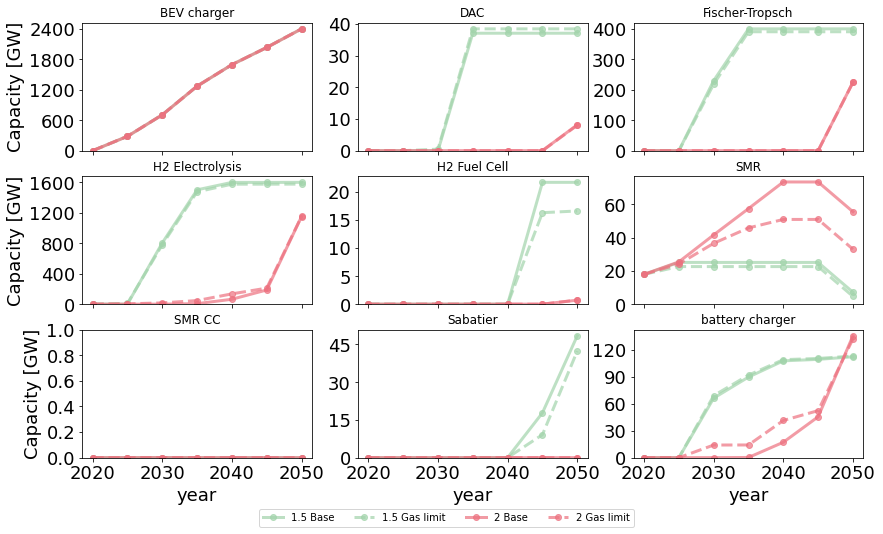

In [19]:
fig,axes = plt.subplots(3,3,figsize=(14,8),sharex=True)
axes = axes.flatten()

for i,tech in enumerate(df.index):
    df_i = df.loc[tech].unstack(level=0)
    df_i.index = df_i.index.astype(int)
    df_i.rename(columns={'1.5_base':'1.5 Base','1.5_no_gas':'1.5 Gas limit','2_base':'2 Base','2_no_gas':'2 Gas limit'},inplace=True)

    df_i.plot(ax=axes[i],
                legend=False,
                style=['-','--','-','--'],
                color=['#A2D4AB','#A2D4AB','#ED717F','#ED717F'],
                marker='o',
                alpha=0.7,
                linewidth=3,
                #color=['tab:blue','tab:blue','tab:orange','tab:orange']
                )
    axes[i].set_title(tech)
    start,end = axes[i].get_ylim()
    axes[i].set_ylim(0,max((end,1)))
    axes[i].yaxis.set_major_locator(plt.MaxNLocator(5))
    axes[i].xaxis.set_major_locator(plt.MaxNLocator(4))
    axes[i].set_xlabel('year')
axes[0].set_ylabel('Capacity [GW]')
axes[3].set_ylabel('Capacity [GW]')
axes[6].set_ylabel('Capacity [GW]')
#axes[9].set_ylabel('Capacity [GW]')
#axes[12].set_ylabel('Capacity [GW]')
axes[-1].legend(ncol=4,bbox_to_anchor=(0, -0.4),borderaxespad=0)

plt.savefig('../figures/other_capacites.pdf',bbox_inches='tight')

### Storage capacities 

In [20]:
store_techs = ['battery',
                'H2',
                #'Li ion'
                #'residential rural water tanks',
                #'services rural water tanks', 
                'urban central water tanks',
                #'residential urban decentral water tanks',
                #'services urban decentral water tanks'
                ]
df = nodal_capacities.loc[('stores',slice(None),store_techs)]
df.rename({'urban central water tanks':'thermal water tanks'},inplace=True)

df= df.groupby(level=2).sum() * 1e-3

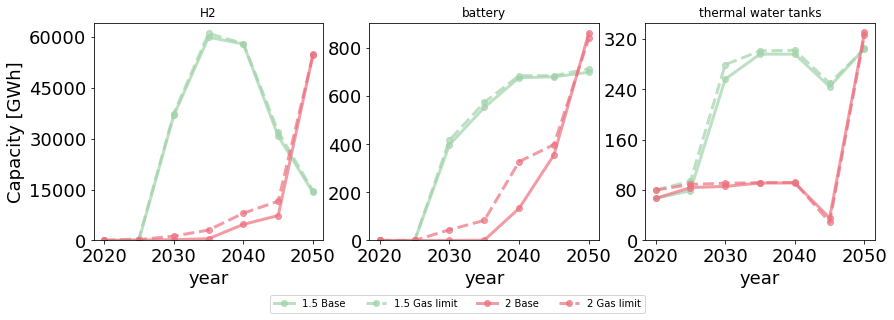

In [21]:
fig,axes = plt.subplots(1,3,figsize=(14,4),sharex=True)
axes = axes.flatten()

for i,tech in enumerate(df.index):
    df_i = df.loc[tech].unstack(level=0)
    df_i.index = df_i.index.astype(int)
    df_i.rename(columns={'1.5_base':'1.5 Base','1.5_no_gas':'1.5 Gas limit','2_base':'2 Base','2_no_gas':'2 Gas limit'},inplace=True)

    df_i.plot(ax=axes[i],
                legend=False,
                style=['-','--','-','--'],
                color=['#A2D4AB','#A2D4AB','#ED717F','#ED717F'],
                marker='o',
                alpha=0.7,
                linewidth=3,
                #color=['tab:blue','tab:blue','tab:orange','tab:orange']
                )
    axes[i].set_title(tech)
    start,end = axes[i].get_ylim()
    axes[i].set_ylim(0,max((end,1)))
    axes[i].yaxis.set_major_locator(plt.MaxNLocator(5))
    axes[i].xaxis.set_major_locator(plt.MaxNLocator(4))
    axes[i].set_xlabel('year')
axes[0].set_ylabel('Capacity [GWh]')
#axes[3].set_ylabel('Capacity [GW]')
#axes[6].set_ylabel('Capacity [GW]')
#axes[9].set_ylabel('Capacity [GW]')
#axes[12].set_ylabel('Capacity [GW]')
axes[-1].legend(ncol=4,bbox_to_anchor=(0, -0.25),borderaxespad=0)

plt.savefig('../figures/storage_capacites.pdf',bbox_inches='tight')

In [22]:
gas_techs = ['H2 Electrolysis1',
            'biogas to gas1',
            'Sabatier1',
            'SMR1',
            'Fischer-Tropsch1',
            'SMR CC1',
            #'helmeth1',
            ]


df = supply_energy.loc[(slice(None),'links',gas_techs)]
df.index = df.index.get_level_values(2)
df.index = [i[:-1] for i in df.index]
df = df *1e-6

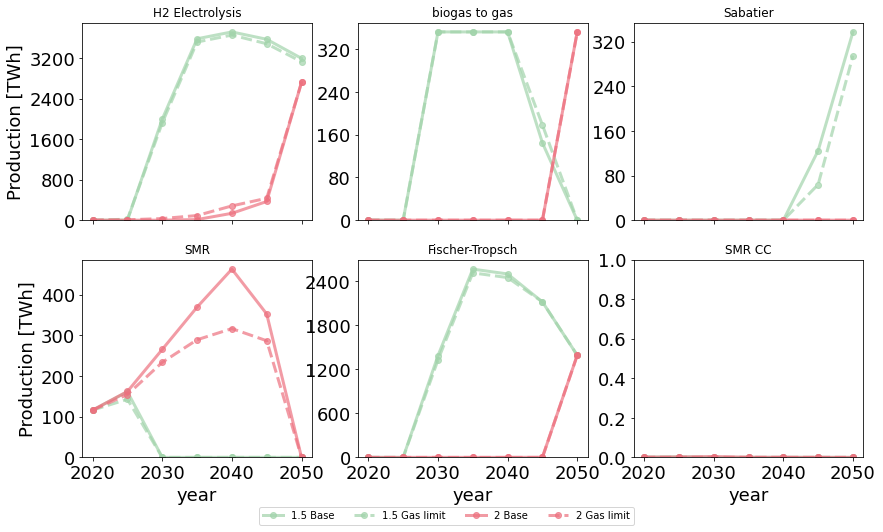

In [23]:
fig,axes = plt.subplots(2,3,figsize=(14,8),sharex=True)
axes = axes.flatten()

for i,tech in enumerate(df.index):
    df_i = df.loc[tech].unstack(level=0)
    df_i.index = df_i.index.astype(int)
    df_i.rename(columns={'1.5_base':'1.5 Base','1.5_no_gas':'1.5 Gas limit','2_base':'2 Base','2_no_gas':'2 Gas limit'},inplace=True)

    df_i.plot(ax=axes[i],
                legend=False,
                style=['-','--','-','--'],
                color=['#A2D4AB','#A2D4AB','#ED717F','#ED717F'],
                marker='o',
                alpha=0.7,
                linewidth=3,
                #color=['tab:blue','tab:blue','tab:orange','tab:orange']
                )
    axes[i].set_title(tech)
    start,end = axes[i].get_ylim()
    axes[i].set_ylim(0,max((end,1)))
    axes[i].yaxis.set_major_locator(plt.MaxNLocator(5))
    axes[i].xaxis.set_major_locator(plt.MaxNLocator(4))
    axes[i].set_xlabel('year')
axes[0].set_ylabel('Production [TWh]')
axes[3].set_ylabel('Production [TWh]')
axes[-1].legend(ncol=4,bbox_to_anchor=(0, -0.25),borderaxespad=0)

plt.savefig('../figures/syngas_production.pdf',bbox_inches='tight')

## Primary energy plot

In [24]:
def make_primary_energy_df():
    co2_carriers = ["co2", "co2 stored", "process emissions"]
    v = [i for i in supply_energy.index.levels[0] if i not in co2_carriers]

    df = supply_energy.loc[(v,['generators','storage_units','stores'],slice(None))]
    df = df.loc[df.max(axis=1)>1e-2]
    df = df.groupby(level=2).sum() * 1e-6
    df = df.groupby(df.index.map(rename_techs)).sum()

    df_hp = supply_energy.loc[supply_energy.index.get_level_values(2).str.contains('heat pump')]
    df_hp.index = [i[:-1] if ((i != "co2") and (i[-1:] in ["0","1","2","3"])) else i for i in df_hp.index.get_level_values(2)]
    df_hp = df_hp.groupby(df_hp.index).sum() * 1e-6

    df = df.append(df_hp)
    tech_names = {'gas':'gas','air heat pump':'ambient heat', 'biogas':'biomass', 'coal':'coal', 'ground heat pump':'ambient heat',
                        'hydroelectricity':'hydro','hydro':'hydro', 'lignite':'lignite', 'offshore wind (AC)':'wind','offwind':'wind','onwind':'wind','offshore wind':'wind',
                        'offshore wind (DC)':'wind', 'oil':'oil', 'onshore wind':'wind', 'solar PV':'solar',
                        'solar rooftop':'solar', 'solar thermal':'solar', 'solid biomass':'biomass', 'uranium':'uranium','nuclear':'nuclear',
                        'residential rural ground heat pump':'ambient heat',
                        'residential urban decentral air heat pump':'ambient heat',
                        'services rural ground heat pump':'ambient heat',
                        'services urban decentral air heat pump':'ambient heat',
                        'urban central air heat pump':'ambient heat',
       }

    df = df.groupby([tech_names[t] for t in df.index]).sum()

    return df


In [25]:
def plot_energy(scen,ax,df=None,desired_order_list=None):
    if df is None:
        #df = make_primary_energy_df()
        df = make_historic_primary_energy()
    if desired_order_list is None:
        desired_order_list = ['gas','coal','lignite','oil' , 'hydro', 'wind'  , 'solar', 'biomass', 'uranium','ambient heat']

    #df = df.loc[:,df.columns.get_level_values(1)!='2020']

    title_scen = {'1.5_base':'Baseline','1.5_no_gas':'Gas limit','2_base':'Baseline','2_no_gas':'Gas limit'}
    df_dict = df[scen].T.to_dict(orient='list')
    df_dict = {k: df_dict[k] for k in desired_order_list}
    #ax.stackplot(df[scen].columns,df_dict.values(),labels=df_dict.keys(),colors=[tech_colors[t] for t in diff_dict.keys()],step='mid');

    df.loc[desired_order_list,scen].T.plot(kind='bar',stacked=True,width=0.9,color=[tech_colors[t] for t in desired_order_list],ax=ax,legend=False)    
    #ax.set_title(title_scen[scen],fontsize=fs,fontweight='bold')
    ax.set_ylabel(rf"$\bf{title_scen[scen]}$" + '\nPrimary energy [TWh]')

In [26]:
def make_historic_primary_energy():
    df_historic  = pd.read_excel('../data/EU, NO, UK primary energy source in 2019 (kTOE).xlsx',index_col=0).loc['EU + NO + UK']
    df_historic.rename({'heat pump':'ambient heat','geothermal':'other renewables and biofuels','non-renewable waste':'other renewables and biofuels','electricity':'other renewables and biofuels','uranium':'nuclear'},inplace=True)
    kToe_to_TWh = 1.163E-2
    df_historic = df_historic.groupby(level=0).sum()*kToe_to_TWh
    df_historic = df_historic.to_frame(name=('1.5_base','2020'))
    df_historic[('2_base','2020')] = df_historic[('1.5_base','2020')]
    df_historic[('2_no_gas','2020')] = df_historic[('1.5_base','2020')]
    df_historic[('1.5_no_gas','2020')] = df_historic[('1.5_base','2020')]

    df = make_primary_energy_df()
    df.rename({'offshore wind':'wind','onshore wind':'wind'},inplace=True)
    df = df.groupby(level=0).sum()
    df = df.loc[:,df.columns.get_level_values(1)!='2020']
    df = pd.concat((df_historic,df),axis=1)
    return df 


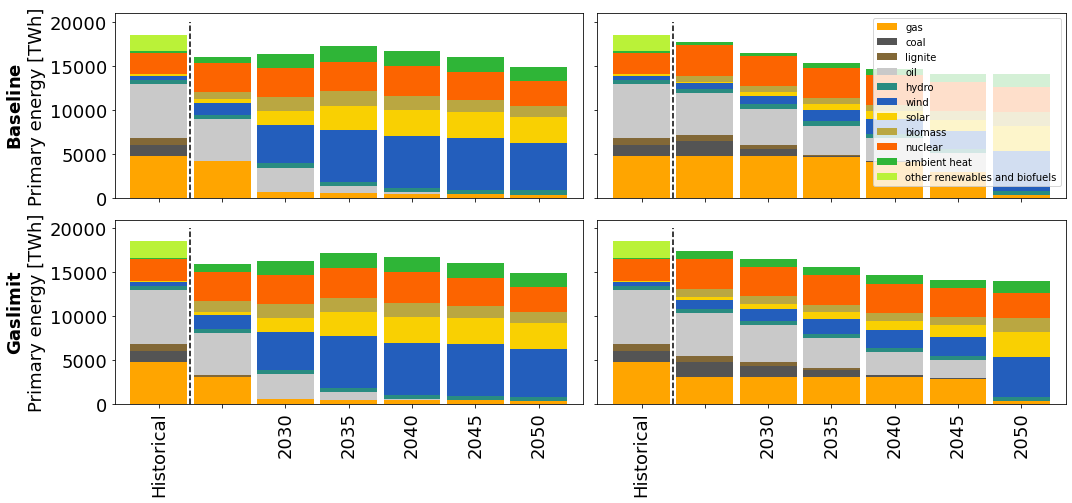

In [27]:
fig,ax = plt.subplots(2,2,figsize=(15,7),sharex=True,sharey=True)
desired_order_list=['gas','coal','lignite','oil', 'hydro',  'wind', 'solar', 'biomass', 'nuclear','ambient heat','other renewables and biofuels']
ax = ax.flatten()

scenarios = ['1.5_base','2_base','1.5_no_gas','2_no_gas']

for ax_i,scen in zip(ax,scenarios):
    plot_energy(scen, ax=ax_i,desired_order_list=desired_order_list)

ax[1].legend(loc='upper right') # Not needed when we merge with the other figure
#ax[0].set_ylabel('Primary energy [TWh]')
#ax[2].set_ylabel('Primary energy [TWh]')

labels = [item.get_text() for item in ax[3].get_xticklabels()]
labels[0] = 'Historical'
labels[1] = ''
ax[3].set_xticklabels(labels)

ax[0].vlines(0.5,0,20000,color='black',linestyle='--')
ax[1].vlines(0.5,0,20000,color='black',linestyle='--')
ax[2].vlines(0.5,0,20000,color='black',linestyle='--')
ax[3].vlines(0.5,0,20000,color='black',linestyle='--')

plt.tight_layout()
plt.savefig('../figures/Primary_energy_grid.jpeg',dpi=1000,bbox_inches='tight')

## Prices figure

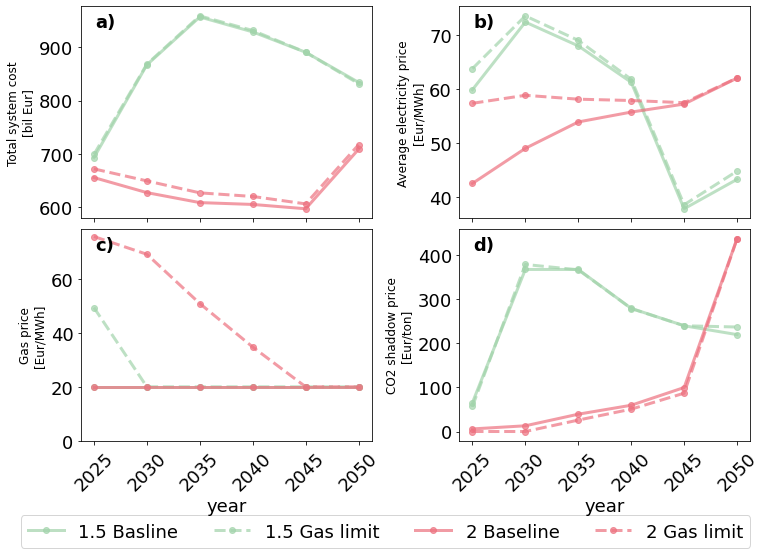

In [32]:
rc('text', usetex=False)
fig,ax = plt.subplots(2,2,figsize=(12,8),sharex=True)
ax = ax.flatten()

df = metrics.loc['co2_shadow'].unstack(level=0).iloc[1:,:]
df.rename(columns={'1.5_base':'1.5 Base','1.5_no_gas':'1.5 Gas limit','2_base':'2 Base','2_no_gas':'2 Gas limit'},inplace=True)
df.columns.name = 'scenario'
df.index = df.index.astype(int)
df.plot(ax=ax[3],
        style=['-','--','-','--'],
        color=['#A2D4AB','#A2D4AB','#ED717F','#ED717F'],
        linewidth=3,
        #drawstyle='steps-mid',
        alpha=0.7,
        marker='o',
        legend=False)
ax[3].set_ylabel('CO2 shaddow price\n[Eur/ton]',fontsize=12)
#ax[3].legend(loc='upper left')

# Total system cost
df = metrics.loc['total costs']*1e-9
df = df.unstack(level=0).iloc[1:,:]
df.rename(columns={'1.5_base':'1.5 Basline','1.5_no_gas':'1.5 Gas limit','2_no_gas':'2 Gas limit','2_base':'2 Baseline'},inplace=True)
df.index = df.index.astype(int)
df.plot(ax=ax[0],
        style=['-','--','-','--'],
        color=['#A2D4AB','#A2D4AB','#ED717F','#ED717F'],
        linewidth=3,
        #drawstyle='steps-mid',
        alpha=0.7,
        marker='o',
        legend=False)
ax[0].set_ylabel('Total system cost\n[bil Eur]',fontsize=12)

# Gas price
df = gas_prices.pivot(index='year',columns='scenario').iloc[1:,:] + 20.1
df.columns = df.columns.get_level_values(1)
df.rename(columns={'1.5':'1.5 Gas limit','2':'2 Gas limit'},inplace=True)
df['1.5 Base'] = 20.1
df['2 Base'] = 20.1
df.index = df.index.astype(int)
df.plot(ax=ax[2],
        style=['--','--'],
        color=['#A2D4AB','#ED717F'],
        linewidth=3,
        #drawstyle='steps-mid',
        alpha=0.7,
        marker='o',
        legend=False)
ax[2].set_ylabel('Gas price\n[Eur/MWh]',fontsize=12)
start, end = ax[2].get_ylim()
ax[2].set_ylim((0, end))

# El price
df = prices.loc['mean'].unstack(level=0).iloc[1:,:]
df.index = df.index.astype(int)
df.plot(ax=ax[1],style=['-','--','-','--'],color=['#A2D4AB','#A2D4AB','#ED717F','#ED717F'],
        linewidth=3,
        #drawstyle='steps-mid',
        alpha=0.7,
        marker='o',
        legend=False)
ax[1].set_ylabel('Average electricity price\n[Eur/MWh]',fontsize=12)


ax[2].xaxis.set_ticks(np.arange(2025, 2055, 5))
ax[2].tick_params(axis='x', labelrotation = 45)
ax[3].tick_params(axis='x', labelrotation = 45)
ax[2].set_xlabel('year')
ax[3].set_xlabel('year')

#ax[0].annotate('test',xy=(2030,860),xytext=(2030,750),xycoords='data', arrowprops=dict(facecolor='black', shrink=0.05))
#ax[3].xaxis.set_ticks(np.arange(-1, 4, 5))

plt.subplots_adjust(wspace=0.3,hspace=0.05)


for ax_i,t in zip(ax,['a)','b)','c)','d)',]):
    ax_i.text(0.05,0.9,t,transform = ax_i.transAxes,fontweight="bold",fontsize=fs)

ax[0].legend(ncol=4,bbox_to_anchor=(2.3, -1.4),borderaxespad=0,fontsize=fs)

plt.savefig('../figures/prices.pdf',bbox_inches='tight')

## Summary Figure

In [35]:
def plot_summary(scen,ax):
    df = make_primary_energy_df()
    #df.loc[:,df.columns.get_level_values(1)=='2020'] = 0


    diff = df[f'{scen}_no_gas'] - df[f'{scen}_base']
    diff.iloc[diff.values<0] = 0
    diff_dict = diff.groupby(level=0).sum().T.to_dict(orient='list')

    diff_dict['gas'] = supply_energy.loc[('gas','generators',slice(None)),f'{scen}_no_gas'].sum().values *1e-6
    diff.loc['gas'] = supply_energy.loc[('gas','generators',slice(None)),f'{scen}_no_gas'].sum().values *1e-6

    diff['2020'] = 0


    desired_order_list = ['gas','coal','lignite','oil' , 'hydro',  'wind', 'solar', 'biomass', 'nuclear','ambient heat']
    diff_dict = {k: diff_dict[k] for k in desired_order_list}

    df_base = supply_energy.loc[('gas','generators',slice(None)),f'{scen}_base'].sum()[1:] * 1e-6
    ax.plot([0.5,1,2,3,4,5,6,6.5],df_base.values[[0,0,1,2,3,4,5,5]],label='Gas use (unlimited)',linewidth=3,color='black',drawstyle='steps-mid')

    #df_base.plot(ax=ax,label='Gas use (unlimited)',linewidth=5,color='black',drawstyle='steps-mid')
    df_no_gas = supply_energy.loc[('gas','generators',slice(None)),f'{scen}_no_gas'].sum()[1:] * 1e-6
    ax.plot([-0.5,1,2,3,4,5,6.5],[3100]*7,label='Gas use (unlimited)',linewidth=3,color='black',linestyle='--',drawstyle='steps-mid')
    #df_no_gas.plot(ax=ax,label='Gas use (limited)',linewidth=5,color='black',linestyle='--',drawstyle='steps-mid')

    diff.loc[desired_order_list].T.plot(kind='bar',stacked=True,width=0.9,color=[tech_colors[t] for t in desired_order_list],ax=ax,legend=False)    

    #ax.stackplot(list(diff.columns),diff_dict.values(),labels=diff_dict.keys(),colors=[tech_colors[t] for t in diff_dict.keys()],step='mid')
    #ax.fill_between(list(diff.columns),np.sum(list(diff_dict.values()),axis=0),supply_energy.loc[('gas','generators',slice(None)),f'{scen}_base'].sum() * 1e-6,hatch='//',color='white',edgecolor='black',label='Efficiency improvements')
    #ax.legend(loc='upper right')
    scen_title = {'1.5':'1.5C gas substitution','2':'2C gas substitution'}
    #ax.set_title(scen_title[scen],fontweight="bold",fontsize=fs)
    ax.set_xlabel('Year')
    ax.set_ylabel(r"$\bf{Difference}$" + '\nPrimary energy [TWh]')
    ax.set_xticks(np.arange(7))
    #ax.legend(loc='upper right')

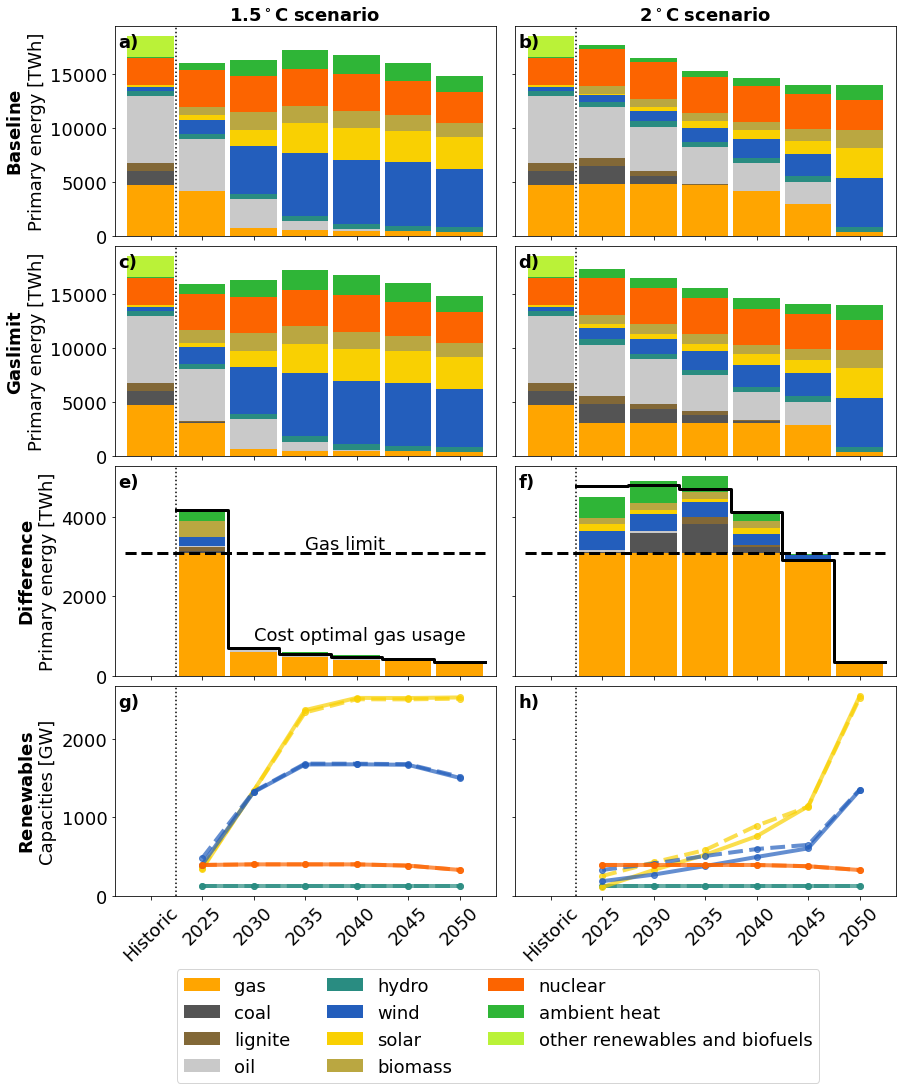

In [36]:
# Combined 
fig,ax = plt.subplots(4,2,figsize=(14,16),sharey='row',sharex=True)
ax = ax.flatten()

scenarios = ['1.5_base','2_base','1.5_no_gas','2_no_gas']
for ax_i,scen in zip(ax[:4],scenarios):
    plot_energy(scen, ax=ax_i,
                desired_order_list=['gas','coal','lignite','oil', 'hydro',  'wind', 'solar', 'biomass', 'nuclear','ambient heat','other renewables and biofuels']
)

scenarios = ['1.5','2']
for ax_i,scen in zip(ax[[4,5]],scenarios):
    plot_summary(scen,ax_i)

df = gen_df_for_cap_plot()
#df = df.loc[:,df.columns.get_level_values(1)!='2020']
for i,scen in enumerate(['1.5','2']):
    df_i = df.loc[:,[f'{scen}_base',f'{scen}_no_gas']].T.unstack(level=0)
    df_i.loc['2020'] = np.nan

    #df_i.index = df_i.index.astype(int)
    
    df_i.plot(color=[tech_colors[t] for t in list(df_i.columns.get_level_values(0))],
                style=['-','--']*10,
                marker='o',
                alpha=0.7,
                ax=ax[i+6],
                linewidth=4,
                legend=False,
                label='test',
                #drawstyle='steps-mid'
                )
    ax[i+6].set_ylabel(r"$\bf{Renewables}$"+'\nCapacities [GW]')
    ax[i+6].set_xlabel('Year')
    #ax[i+6].set_title(f'{scen}C Renewable capacities',fontweight="bold",fontsize=fs)
    #ax[i+6].xaxis.set_major_locator(plt.MaxNLocator(7))

for ax_i in ax:
    start,end = ax_i.get_ylim()
    start = 0
    ax_i.set_ylim(start,end)
    ax_i.vlines(0.5,start,end,color='black',linestyle=':')

labels = [item.get_text() for item in ax[7].get_xticklabels()]
labels[0] = 'Historic'
ax[7].set_xticklabels(labels)
ax[7].set_xlabel('')
ax[6].set_xlabel('')
ax[6].tick_params(axis='x', labelrotation = 45)
ax[7].tick_params(axis='x', labelrotation = 45)

ax[0].set_title(r"$\bf{1.5^\circ C \; scenario}$",fontweight="bold",fontsize=fs)
ax[1].set_title(r"$\bf{2^\circ C \; scenario}$",fontweight="bold",fontsize=fs)

ax[4].annotate('Gas limit',xy=(3,3200),fontsize=fs)
ax[4].annotate('Cost optimal gas usage',xy=(2,900),fontsize=fs)

fig.subplots_adjust(wspace=0.05,hspace=0.05)
ax[3].legend(prop={'size':fs},ncol=3,bbox_to_anchor=(0.8, -2.45),borderaxespad=0)

#ax[6].legend(prop={'size':fs},ncol=3,bbox_to_anchor=(0.8, -2.45),borderaxespad=0)

for ax_i,t in zip(ax,['a)','b)','c)','d)','e)','f)','g)','h)']):
    ax_i.text(0.01,0.9,t,transform = ax_i.transAxes,fontweight="bold",fontsize=fs)

plt.savefig(f'../figures/primary_energy_grid2.pdf',dpi=500,bbox_inches='tight')

## Graphical abstract plot

In [37]:
def plot_graph_abstract(scen,ax):
    df = make_primary_energy_df()
    df = df.loc[:,df.columns.get_level_values(1)!='2020']


    diff = df[f'{scen}_no_gas'] - df[f'{scen}_base']
    diff.iloc[diff.values<0] = 0


    diff_dict = diff.groupby(level=0).sum().T.to_dict(orient='list')

    diff_dict['gas'] = supply_energy.loc[('gas','generators',slice(None)),f'{scen}_no_gas'].sum().values[1:] *1e-6
    diff.loc['gas'] = supply_energy.loc[('gas','generators',slice(None)),f'{scen}_no_gas'].sum().values[1:] *1e-6



    desired_order_list = ['gas','ambient heat' , 'wind', 'solar', 'biomass','oil','coal','lignite']
    diff_dict = {k: diff_dict[k] for k in desired_order_list}

    df_base = supply_energy.loc[('gas','generators',slice(None)),f'{scen}_base'].sum()[1:] * 1e-6
    ax.plot([0,1,2,3,4,5],df_base.values,label=None,linewidth=5,color='black',)

    #df_base.plot(ax=ax,label='Gas use (unlimited)',linewidth=5,color='black',drawstyle='steps-mid')
    df_no_gas = supply_energy.loc[('gas','generators',slice(None)),f'{scen}_no_gas'].sum()[1:] * 1e-6
    #ax.plot([0,1,2,3,4,5],df_no_gas.values,label='Gas use (unlimited)',linewidth=5,color='black',linestyle='--',)
    ax.plot([-0.5,1,2,3,4,5,6.5],[3100]*7,label=None,linewidth=3,color='black',linestyle='--',drawstyle='steps-mid')

    #df_no_gas.plot(ax=ax,label='Gas use (limited)',linewidth=5,color='black',linestyle='--',drawstyle='steps-mid')

    #diff.loc[desired_order_list].T.plot(kind='bar',stacked=True,width=0.9,color=[tech_colors[t] for t in desired_order_list],ax=ax,legend=False)    

    ax.stackplot(list(diff.columns),diff_dict.values(),labels=diff_dict.keys(),colors=[tech_colors[t] for t in diff_dict.keys()])
    #ax.fill_between(list(diff.columns),np.sum(list(diff_dict.values()),axis=0),supply_energy.loc[('gas','generators',slice(None)),f'{scen}_base'].sum() * 1e-6,hatch='//',color='white',edgecolor='black',label='Efficiency improvements')
    #ax.legend(loc='upper right')
    scen_title = {'1.5':'1.5C gas substitution','2':'2C gas substitution'}
    #ax.set_title(scen_title[scen],fontweight="bold",fontsize=fs)
    ax.set_xlabel('Year')
    ax.set_ylabel('Primary energy [TWh]')
    ax.set_xticks(np.arange(7))
    #ax.legend(loc='upper right')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

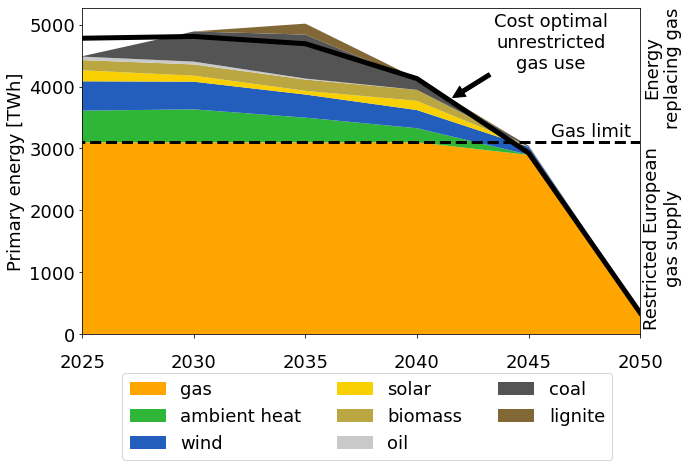

In [38]:
# Graphical abstract
scen = '2'
fig,ax = plt.subplots(1,1,figsize=(10,6),sharey=True)
#for ax_i,scen in zip(ax,scenarios):
plot_graph_abstract(scen,ax)

fig.subplots_adjust(wspace=0.05)
ax.legend(prop={'size':fs},ncol=3,bbox_to_anchor=(0.95, -0.12),borderaxespad=0)

ax.set_xlim([0,5])
ax.tick_params(axis='x', which='major', pad=15)
ax.set_xlabel('')

ax.text(5.2,150,
        'Restricted European\ngas supply',
        fontsize=fs,
        rotation=90,
        horizontalalignment='center',)
ax.text(4.2,3200,'Gas limit',fontsize=fs)
ax.annotate('Energy\nreplacing gas',
            xy=(2.8,3700),
            xytext=(5.2,3400),
            fontsize=fs,
            horizontalalignment='center',
            rotation=90,
            #arrowprops=dict(facecolor='black', shrink=0.05)
            )
#ax.annotate('Lower efficiency',
#            xy=(2,5000),
#            xytext=(3.2,5000),
#            fontsize=fs,
#            horizontalalignment='center',
#            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('Cost optimal\nunrestricted\ngas use',
            xy=(3.3,3800),
            xytext=(4.2,4300),
            fontsize=fs,
            horizontalalignment='center',
            arrowprops=dict(facecolor='black', shrink=0.05))


plt.savefig(f'../figures/GraphAbstract.pdf',dpi=500,bbox_inches='tight')